# Test Notebook for nisarcryodb
---

This note book is used to develop, test, and document the  `nisarcryodb` class, which is used to query the NISAR cal/val db for GPS data from cryosphere validation sites.


In [1]:
%load_ext autoreload
%autoreload 2
import nisarcryodb
from psycopg2 import sql
import matplotlib.pyplot as plt
import numpy as np

## Initialize nisarcryodb Object

This step initializes the connection to the nisar cal/val data base. It requires a cal/val database user name and passwd.

In [8]:
myConnection = nisarcryodb.nisarcryodb()

User name:  irj
Password:  ········


## List Schema

List all of the schema in the database. 

In [9]:
schemas = myConnection.listSchema(quiet=False)

crop_area
pg_catalog
information_schema
soil_moisture
inundation
disturbance
seaice
biomass_save
biomass
pg_temp_8
pg_toast_temp_8
nisar
permafrost
sites
tiger
tiger_data
topology
public
solidearth
landice
pg_temp_16
pg_toast_temp_16
corner_reflectors


## List Table Names for Schema

List the names of the table under the landice schema.

In [10]:
myConnection.listSchemaTableNames('landice');

gps_data_version
requirement
site
l3_product
gps_station
validation_run_gps_data_jct
validation_run
l3_product_calval_site_jct
l3_product_requirement_jct
velocity_data
gps_data


## List Column Names for Table

List the column names for a table (e.g., gps_station) and schema (e.g., landice).

In [11]:
stationColumns = myConnection.listTableColumns('landice', 'gps_station', quiet=False)

station_id, station_name, reflat, reflon, refheight, poc_name, poc_email, station_geom, site_id


This time get the columns for the gps_data table. Use `returnType=True` to get the data type for each column.

In [12]:
gpsColumns, gpsDataTypes = myConnection.listTableColumns('landice', 'gps_data', returnType=True)

gps_data_id, station_id, date_uploaded, decimal_year, nominal_doy, lat, lon, ht_abv_eps, std, data_geom, version_id
integer, integer, date, double precision, integer, double precision, double precision, double precision, double precision, USER-DEFINED, integer


## List Column Values

Get the `station_name` column values for `landice.gps_station` tables 

In [13]:
myConnection.getColumn('landice', 'gps_station', 'station_name')

['LORG',
 'test',
 'NIU1',
 'NIU2',
 'NIU3',
 'NIU4',
 'NIU5',
 'NIT0',
 'NIT1',
 'NIT2',
 'NIT3',
 'NIT4',
 'NIT5',
 'NIL1',
 'NIL2',
 'NIL3',
 'NIL4',
 'NIL5']

Get the `latitude` column values for `landice.gps_data` tables 

In [14]:
lat = myConnection.getColumn('landice', 'gps_data', 'lat');
lat[0:10]

[67.11978615127572,
 67.11978618058903,
 67.119786154185,
 67.11978616763491,
 67.11978613551105,
 67.11978610191011,
 67.11978602025852,
 67.1197859849196,
 67.1197858960912,
 67.11978588373174]

## Station Name to ID

Determine the station ID (e.g., 22) from the station name (e.g., LORG).

In [15]:
myConnection.stationNameToID('LORG')

22

## Get GPS Data for Date Range

Return all the data for a designated station for the decimal date range (d1, d2). 

In [16]:
d1 = 2019.8165544457129-1
d2 = 2019.819178050482+1
myData = myConnection.getStationDateRangeData('LORG', d1, d2, schemaName='landice', tableName='gps_data')

In [17]:
myData

,gps_data_id,station_id,date_uploaded,decimal_year,nominal_doy,lat,lon,ht_abv_eps,std,data_geom,version_id
0,1,22,2024-08-14,2019.816095,299,-78.178644,170.035773,-8.166388,0.052630,0101000020E61000002FAA480E254165406A8E1EE66E8B...,1
1,2,22,2024-08-14,2019.816096,299,-78.178644,170.035774,-8.164225,0.052005,0101000020E6100000F6F51A0F25416540DCEE4AE66E8B...,1
2,3,22,2024-08-14,2019.816097,299,-78.178644,170.035774,-8.165435,0.051403,0101000020E61000004BD2AF0F25416540A41B26E66E8B...,1
3,4,22,2024-08-14,2019.816098,299,-78.178644,170.035774,-8.182960,0.050820,0101000020E610000028D5851025416540DFD121E66E8B...,1
4,5,22,2024-08-14,2019.816099,299,-78.178644,170.035775,-8.187331,0.050257,0101000020E61000003146AB10254165402F48FAE56E8B...,1
...,...,...,...,...,...,...,...,...,...,...,...
3595,3596,22,2024-08-14,2019.819515,299,-78.178624,170.035779,-8.299269,0.032706,0101000020E610000085937519254165408138EE946E8B...,1
3596,3597,22,2024-08-14,2019.819516,299,-78.178624,170.035779,-8.306964,0.032744,0101000020E61000008C695E192541654014ABF6946E8B...,1
3597,3598,22,2024-08-14,2019.819517,299,-78.178624,170.035779,-8.318135,0.032788,0101000020E6100000F0C5161925416540BDC5FD946E8B...,1
3598,3599,22,2024-08-14,2019.819518,299,-78.178624,170.035778,-8.340532,0.032837,0101000020E61000001A04A21825416540094713956E8B...,1


Text(0, 0.5, 'latitude')

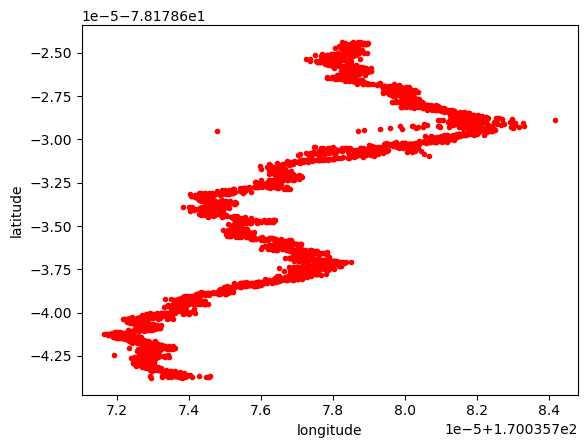

In [18]:
plt.plot(myData['lon'], myData['lat'], 'r.')
plt.xlabel('longitude')
plt.ylabel('latitude')

## Get Station Information

Return the table with all of the top-level station data (e.g,, name, id, position, etc).

In [19]:
myConnection.getTableListing(schemaName='landice', tableName='gps_station')

,station_id,station_name,reflat,reflon,refheight,poc_name,poc_email,station_geom,site_id
0,22,LORG,34.463000,-118.550000,NaN,None,None,0101000020E61000003333333333A35DC025068195433B...,3
1,23,test,34.045000,-119.541000,NaN,None,None,0101000020E6100000B4C876BE9FE25DC0F6285C8FC205...,3
2,17,NIU1,67.119742,-47.139061,NaN,None,None,0101000020E6100000149337C0CC9147C04A7D59DAA9C7...,2
3,18,NIU2,67.131502,-46.222216,NaN,None,None,0101000020E6100000F052EA92711C47C0F3565D876AC8...,2
4,19,NIU3,67.146943,-45.367189,NaN,None,None,0101000020E6100000B939950C00AF46C012D89C8367C9...,2
5,20,NIU4,67.112244,-44.325733,NaN,None,None,0101000020E61000002E1D739EB12946C0064B75012FC7...,2
6,21,NIU5,67.120695,-43.182892,NaN,None,None,0101000020E61000009B594B01699745C09B728577B9C7...,2
7,1,NIT0,-80.330000,154.340000,1406.0,None,None,0101000020E61000007B14AE47E14A634085EB51B81E15...,1
8,2,NIT1,-79.800000,161.330000,34.0,None,None,0101000020E6100000C3F5285C8F2A64403333333333F3...,1
9,3,NIT2,-79.670000,164.800000,49.0,None,None,0101000020E61000009A999999999964407B14AE47E1EA...,1


## Get Level 3 Products

Get all L3 products from 2015 to 2023. Filters can be specified by column heading and value (e.g., `filters={'measurement_type': 'velocity'}`. Wild can be set off with % signs. For example, to list only the velocity files with 'vx' in the name will be accomplished by `filters={'product_path': '%vx%'}`.

In [27]:
date1 = '01-01-2015'
date2 = '12-31-2023'
myConnection.getL3DateRangeData(date1, date2, schemaName='landice', tableName='l3_product', filters={'product_path': '%vx%', 'measurement_type': 'velocity'})

product_path
measurement_type


,product_id,start_date,end_date,resolution,accuracy,measurement_type,provider,product_type,product_path,product_version,software_version,config_file_path,date_created,archived,location_geom,notes
0,2,2016-12-01,2017-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test
1,5,2017-12-01,2018-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test
2,8,2018-12-01,2019-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test


## Rollback a Query Error

This will reset the connection after a query fails with an error. Most of the routines should trap errors and automatically rollback.

In [ ]:
myConnection.connection.rollback()

## Close the connection

Close the connection when finished.

In [ ]:
myConnection.close()